In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bring_board import createBoard
from opening_cells import update_board
import time
import os
from scipy.interpolate.rbf import Rbf

from tqdm.notebook import trange

In [2]:
Rbf?

Init signature: Rbf(*args, **kwargs)
Docstring:     
Rbf(*args)

A class for radial basis function interpolation of functions from
N-D scattered data to an M-D domain.

Parameters
----------
*args : arrays
    x, y, z, ..., d, where x, y, z, ... are the coordinates of the nodes
    and d is the array of values at the nodes
function : str or callable, optional
    The radial basis function, based on the radius, r, given by the norm
    (default is Euclidean distance); the default is 'multiquadric'::

        'multiquadric': sqrt((r/self.epsilon)**2 + 1)
        'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
        'gaussian': exp(-(r/self.epsilon)**2)
        'linear': r
        'cubic': r**3
        'quintic': r**5
        'thin_plate': r**2 * log(r)

    If callable, then it must take 2 arguments (self, r). The epsilon
    parameter will be available as self.epsilon. Other keyword
    arguments passed in will be available as well.

epsilon : float, optional
    Adjustable constant for 

In [2]:
def Number(board, choice):
    return board[choice[0]][choice[1]].number

def Is_checked(board, choice, put =None):
    
    if put != None:
        board[choice[0]][choice[1]].is_checked = put
    
    else:
        return board[choice[0]][choice[1]].is_checked

def Adj(board, choice):
    return board[choice[0]][choice[1]].adj

def Cell(board, choice):
    return board[choice[0]][choice[1]]

def prob_of_bomb_in_area(board, prob_board, cell):
    bomb_left_to_mark = cell.number
    number_of_places_bomb_can_be = 0
    for each_adj in cell.adj.values():
        if each_adj and Cell(board, each_adj).is_flaged:
            bomb_left_to_mark -= 1
        if each_adj and not Cell(board, each_adj).is_checked:
            number_of_places_bomb_can_be += 1
    if bomb_left_to_mark != 0:
        prob = combination(number_of_places_bomb_can_be -1 , bomb_left_to_mark -1) / \
            combination(number_of_places_bomb_can_be, bomb_left_to_mark)
    else:
        prob = 0.00001
           
    for each_adj in cell.adj.values():
        if each_adj and not Cell(board, each_adj).is_checked:
            position = Cell(board, each_adj).pos
            if prob != 0.00001 and prob_board[position[0]][position[1]] != 0.00001:
                max_prob = max(prob_board[position[0]][position[1]],
                                                          prob)
                prob_board[position[0]][position[1]] = max_prob                                          
            if prob == 0.00001:
                prob_board[position[0]][position[1]] = 0.00001


def combination(n, r):
    n_fact = 1
    r_fact = 1
    n_r_fact = 1
    n_r = n - r
    for i in range(1, n+1):
        n_fact *= i
    for i in range(1, r+1):
        r_fact *= i
    for i in range(1, n_r+1):
        n_r_fact *= i
    return n_fact/ (r_fact * n_r_fact)

In [3]:
def old_solver(board, num_row, num_col, alpha):
    given_board = np.array(["*" for i in range(num_row) for j in range(num_col)
                    ]).reshape(num_row, num_col)
    number_bomb = number_bomb = int(0.15*(num_col*num_row))
    cell_left  = num_col * num_row
    prob_board = np.array([0.0 for i in range(num_row) for j in range(num_col)
                    ]).reshape(num_row, num_col)

    status = 0
    df = pd.DataFrame()
    while not status:
        action_type = "random"
        choice_list = [[i,j] for i in range(num_row) for j in range(num_col) if not board[i][j].is_checked]
        cell_left = len(choice_list)
        action = 0
        for i in range(num_row):
            for j in range(num_col):
                if board[i][j].is_checked and not board[i][j].is_flaged:
                    total_number_of_adj_checked=0
                    total_number_of_adj_none=0
                    for each_adj in board[i][j].adj.values():
                        try:
                            total_number_of_adj_checked += int(Cell(board, each_adj).is_checked)
                        except:
                            total_number_of_adj_none += 1
                    if (8 - total_number_of_adj_none - total_number_of_adj_checked) > 0:
                        prob_of_bomb_in_area(board, prob_board, board[i][j])

        max_prob_of_bomb = [0, [-1,-1]]
        min_prob_of_bomb = [1, [-1,-1]]
        for i in range(num_row):
            for j in range(num_col):
                if [i,j] in choice_list:
                    if prob_board[i][j] > max_prob_of_bomb[0]:
                        max_prob_of_bomb[0] = prob_board[i][j]
                        max_prob_of_bomb[1] = [i,j]

                    total_number_of_adj_checked=0
                    total_number_of_adj_flag=0
                    for each_adj in Cell(board, [i,j]).adj.values():
                        try:
                            total_number_of_adj_checked += int(Cell(board, each_adj).is_checked)
                            total_number_of_adj_flag += int(Cell(board, each_adj).is_flaged)
                        except:
                            continue

                    if total_number_of_adj_checked - total_number_of_adj_flag > 0:
                        if prob_board[i][j] < min_prob_of_bomb[0]:
                            min_prob_of_bomb[0] = prob_board[i][j]
                            min_prob_of_bomb[1] = [i,j]

        if max_prob_of_bomb[0] > 1 - alpha or min_prob_of_bomb[0] < alpha:
            action_type = "probability"
            if max_prob_of_bomb[0] > 1 - alpha:
                x,y = max_prob_of_bomb[1]
                action = 1
            if min_prob_of_bomb[0] < alpha:
                x,y = min_prob_of_bomb[1]
                action = 0
        else:
            action_type = "random"
            left_cell_prob = [[prob_board[x][y],[x,y]] for x,y in choice_list]
            pick_in_this = [prob_cell[1] for prob_cell in left_cell_prob if prob_cell[0] == min(left_cell_prob)[0]]
            x,y = random.choice(pick_in_this)
        try:
            if len(choice_list):
                choice_list.remove([x,y])
        except:
            pass
        
        board, given_board, status = update_board((x,y), action, num_row,num_col, board,given_board,number_bomb,cell_left)
        prob_board = np.array([0.0 for i in range(num_row) for j in range(num_col)
                        ]).reshape(num_row, num_col)
        #if status == 0:
        #    print("\n\n", given_board)
        #elif status == 1:
        #    print("\n\n", given_board)        
        #else:
        #    print("\n\n", given_board)     

        data = {
            "action_type": [action_type],
            "action" : [action]
        }
        df = pd.concat([df, pd.DataFrame(data)])   

    return df, {"action_type": [action_type],"status": [status], "clicks": [num_row*num_col-len(choice_list)]}

#def main(num_row, 
#         num_col,
#         threshold):
#    board = createBoard(num_row, num_col)
#    df, status = solver(board, num_row, num_col, threshold)
#    df.action = df.action.replace({0: "left", 1: "right"})
#    ct = pd.crosstab(df.action_type, df.action)
#    print(ct,"\n", status)
#    stacked = ct.stack().reset_index().rename(columns={0:'value'})
#    sns.barplot(x=stacked.action_type, y=stacked.value, hue=stacked.action)
#    plt.title("Lost" if status["status"] == -1 else "Win")
#    plt.show()

In [4]:
def new_solver(board, num_row, num_col, alpha):
    given_board = np.array(["*" for i in range(num_row) for j in range(num_col)
                    ]).reshape(num_row, num_col)
    number_bomb = number_bomb = int(0.15*(num_col*num_row))
    cell_left  = num_col * num_row
    prob_board = np.array([0.0 for i in range(num_row) for j in range(num_col)
                    ]).reshape(num_row, num_col)

    status = 0
    df = pd.DataFrame()
    
    def safe(x,y):
        return x == 0 or y == 0 or x == num_row-1 or y == num_col-1
    
    while not status:
        action_type = "random"
        choice_list = [[i,j] for i in range(num_row) for j in range(num_col) if not board[i][j].is_checked]
        opened_list = [[i,j] for i in range(num_row) for j in range(num_col) if board[i][j].is_checked]
        cell_left = len(choice_list)
        action = 0
        for i in range(num_row):
            for j in range(num_col):
                if board[i][j].is_checked and not board[i][j].is_flaged:
                    total_number_of_adj_checked=0
                    total_number_of_adj_none=0
                    for each_adj in board[i][j].adj.values():
                        try:
                            total_number_of_adj_checked += int(Cell(board, each_adj).is_checked)
                        except:
                            total_number_of_adj_none += 1
                    if (8 - total_number_of_adj_none - total_number_of_adj_checked) > 0:
                        prob_of_bomb_in_area(board, prob_board, board[i][j])

        max_prob_of_bomb = [0, [-1,-1]]
        min_prob_of_bomb = [1, [-1,-1]]
        for i in range(num_row):
            for j in range(num_col):
                if [i,j] in choice_list:
                    if prob_board[i][j] > max_prob_of_bomb[0]:
                        max_prob_of_bomb[0] = prob_board[i][j]
                        max_prob_of_bomb[1] = [i,j]

                    total_number_of_adj_checked=0
                    total_number_of_adj_flag=0
                    for each_adj in Cell(board, [i,j]).adj.values():
                        try:
                            total_number_of_adj_checked += int(Cell(board, each_adj).is_checked)
                            total_number_of_adj_flag += int(Cell(board, each_adj).is_flaged)
                        except:
                            continue

                    if total_number_of_adj_checked - total_number_of_adj_flag > 0:
                        if prob_board[i][j] < min_prob_of_bomb[0]:
                            min_prob_of_bomb[0] = prob_board[i][j]
                            min_prob_of_bomb[1] = [i,j]

        if max_prob_of_bomb[0] > 1 - alpha or min_prob_of_bomb[0] < alpha:
            action_type = "probability"
            if max_prob_of_bomb[0] > 1 - alpha:
                x,y = max_prob_of_bomb[1]
                action = 1
            if min_prob_of_bomb[0] < alpha:
                x,y = min_prob_of_bomb[1]
                action = 0
        else:
            action_type = "random"
            if opened_list:
                x ,y = list(zip(*opened_list))
                z = [1]*len(x)
                rbf_adj = Rbf(x, y, z, function='gaussian', epsilon = 0.03 * num_row * num_col)
                x_fine, y_fine = list(zip(*[[i,j] for i in range(num_row) for j in range(num_col)]))
                x_grid, y_grid = np.meshgrid(x_fine, y_fine)
                weight = 1 - rbf_adj(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)
            
                left_cell_prob = [[prob_board[x][y],[x,y]] for x,y in choice_list]
                pick_in_this = [prob_cell[1] for prob_cell in left_cell_prob if prob_cell[0] == min(left_cell_prob)[0]]
                left_weights = [weight[x][y] for x,y in pick_in_this]
                #random.shuffle(pick_in_this)
                x,y =pick_in_this[len(left_weights)-1-left_weights[::-1].index(max(left_weights))]
                #x,y = random.choices(pick_in_this, weights = left_weights)[0]
                
            else:
                left_cell_prob = [[prob_board[x][y],[x,y]] for x,y in choice_list if safe(x,y)]
                pick_in_this = [prob_cell[1] for prob_cell in left_cell_prob if prob_cell[0] == min(left_cell_prob)[0]]
                random.shuffle(pick_in_this)
                x,y = random.choices(pick_in_this)[0]
        try:
            if len(choice_list):
                choice_list.remove([x,y])
        except:
            pass
        
        board, given_board, status = update_board((x,y), action, num_row,num_col, board,given_board,number_bomb,cell_left)
        prob_board = np.array([0.0 for i in range(num_row) for j in range(num_col)
                        ]).reshape(num_row, num_col)
        #if status == 0:
        #    print("\n\n", given_board)
        #elif status == 1:
        #    print("\n\n", given_board)        
        #else:
        #    print("\n\n", given_board)     

        data = {
            "action_type": [action_type],
            "action" : [action]
        }
        df = pd.concat([df, pd.DataFrame(data)])   

    return df, {"action_type": [action_type],"status": [status], "clicks": [num_row*num_col-len(choice_list)]}, given_board

In [6]:
num_row, num_col = (10,10)


In [61]:
board = createBoard(num_row, num_col)
action_type, status, board = new_solver(board, num_row, num_col, 0.1)

In [62]:
status

{'action_type': ['random'], 'status': [-1], 'clicks': [88]}

In [63]:
board

array([['1', '*', '2', '1', '0', '0', '0', '0', '0', '0'],
       ['1', '*', '#', '1', '0', '0', '0', '1', '1', '1'],
       ['1', '2', '2', '1', '0', '0', '0', '2', '#', '2'],
       ['1', '*', '1', '0', '0', '0', '1', '3', '#', '2'],
       ['2', '*', '3', '2', '2', '1', '2', '#', '2', '1'],
       ['*', '3', '#', '#', '2', '#', '2', '2', '2', '1'],
       ['*', '*', '*', '3', '2', '1', '1', '1', '#', '1'],
       ['2', '4', '*', '2', '0', '0', '0', '1', '1', '1'],
       ['*', '*', '*', '2', '0', '0', '0', '0', '0', '0'],
       ['1', '2', '*', '1', '0', '0', '0', '0', '0', '0']], dtype='<U1')

<ipython-input-102-ef73449a6335>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_fine, y_fine, weights);


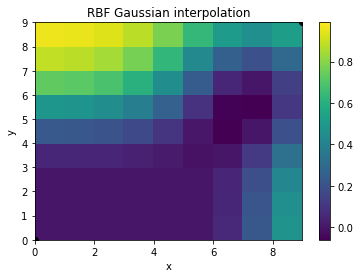

In [102]:
plt.pcolor(x_fine, y_fine, weights);
plt.plot(x, y, 'ok');
plt.xlabel('x'); plt.ylabel('y'); plt.colorbar();
plt.title('RBF Gaussian interpolation');

In [68]:
random.choices([0,1], weights=(0.1, 0.9))

[1]

In [7]:
import copy 

In [430]:
copy.deepcopy?

Signature: copy.deepcopy(x, memo=None, _nil=[])
Docstring:
Deep copy operation on arbitrary Python objects.

See the module's __doc__ string for more info.
File:      c:\users\prans\anaconda3\lib\copy.py
Type:      function


In [13]:
num_row, num_col, threshold = (10,10,0.1)
res_status_o = pd.DataFrame()
res_status_n = pd.DataFrame()
for i in trange(500):
    try:
        board_o = createBoard(num_row, num_col)
        #board_n = copy.deepcopy(board_o)
        df_o, status_o = old_solver(board_o, num_row, num_col, threshold)
        #dfn, status_n = new_solver(board_n, num_row, num_col, threshold)
        res_status_o = pd.concat([res_status_o, pd.DataFrame(status_o)])
        #res_status_n = pd.concat([res_status_n, pd.DataFrame(status_n)])
    except:
        continue

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
res_status_o.status = np.where(res_status_o.status == 1, "Won", "Lost")

<AxesSubplot:xlabel='status', ylabel='action_type'>

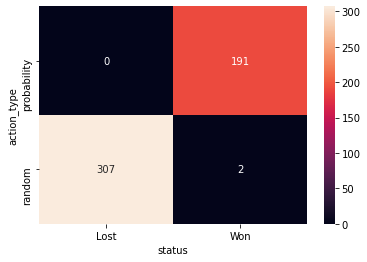

In [19]:
sns.heatmap(pd.crosstab(res_status_o.action_type, res_status_o.status), annot= True, fmt= ".3g")

In [106]:
pd.crosstab(res_status_n.action_type, res_status_n.status)

status,-1,1
action_type,,
probability,0,252
random,247,1


In [107]:
res_status_n["model"] = "new"
res_status_o["model"] = "old"

In [108]:
res_status = pd.concat([res_status_o, res_status_n])

(0.0, 100.0)

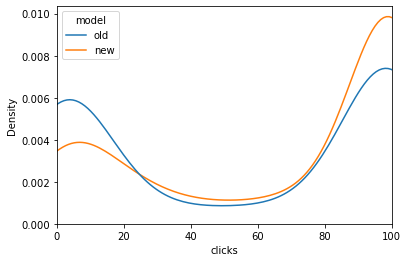

In [109]:
sns.kdeplot(data = res_status, x = "clicks", hue = "model")
plt.xlim(0,100)

In [273]:
x ,y = list(zip(*opened_list))
z = [1]*len(x)

rbf_adj = Rbf(x, y, z, function='inverse', epsilon = 0.01 * num_row * num_col)

x_fine, y_fine = list(zip(*[[i,j] for i in range(num_row) for j in range(num_col)]))

x_grid, y_grid = np.meshgrid(x_fine, y_fine)

weight = 1 - rbf_adj(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

In [274]:
weight[0,5]

0.0

<ipython-input-111-2e232434fb13>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_fine, y_fine, z_grid);


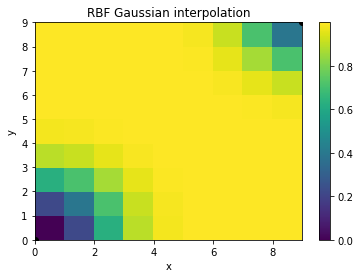

In [111]:
from scipy.interpolate.rbf import Rbf  # radial basis functions
import matplotlib.pyplot as plt
import numpy as np

x, y = list(zip(*[[0,0],[9,9]]))
z = [1]*len(x)

rbf_adj = Rbf(x, y, z, function='gaussian', epsilon = 0.02 * num_row * num_col)

x_fine, y_fine = list(zip(*[[i,j] for i in range(num_row) for j in range(num_col)]))

x_grid, y_grid = np.meshgrid(x_fine, y_fine)

z_grid = 1 - rbf_adj(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

plt.pcolor(x_fine, y_fine, z_grid);
plt.plot(x, y, 'ok');
plt.xlabel('x'); plt.ylabel('y'); plt.colorbar();
plt.title('RBF Gaussian interpolation');

In [107]:
Rbf?

Init signature: Rbf(*args, **kwargs)
Docstring:     
Rbf(*args)

A class for radial basis function interpolation of functions from
N-D scattered data to an M-D domain.

Parameters
----------
*args : arrays
    x, y, z, ..., d, where x, y, z, ... are the coordinates of the nodes
    and d is the array of values at the nodes
function : str or callable, optional
    The radial basis function, based on the radius, r, given by the norm
    (default is Euclidean distance); the default is 'multiquadric'::

        'multiquadric': sqrt((r/self.epsilon)**2 + 1)
        'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
        'gaussian': exp(-(r/self.epsilon)**2)
        'linear': r
        'cubic': r**3
        'quintic': r**5
        'thin_plate': r**2 * log(r)

    If callable, then it must take 2 arguments (self, r). The epsilon
    parameter will be available as self.epsilon. Other keyword
    arguments passed in will be available as well.

epsilon : float, optional
    Adjustable constant for 

In [ ]:
(z_grid*100).flatten().tolist()

In [64]:
x = [[i for i in range(10)] for j in range(10)]
x

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [69]:
x = pd.DataFrame(x)

In [73]:
x.index = x.index.astype(str)
x.columns = x.columns.astype(str)

In [75]:
x.to_dict()

{'0': {'0': 0,
  '1': 0,
  '2': 0,
  '3': 0,
  '4': 0,
  '5': 0,
  '6': 0,
  '7': 0,
  '8': 0,
  '9': 0},
 '1': {'0': 1,
  '1': 1,
  '2': 1,
  '3': 1,
  '4': 1,
  '5': 1,
  '6': 1,
  '7': 1,
  '8': 1,
  '9': 1},
 '2': {'0': 2,
  '1': 2,
  '2': 2,
  '3': 2,
  '4': 2,
  '5': 2,
  '6': 2,
  '7': 2,
  '8': 2,
  '9': 2},
 '3': {'0': 3,
  '1': 3,
  '2': 3,
  '3': 3,
  '4': 3,
  '5': 3,
  '6': 3,
  '7': 3,
  '8': 3,
  '9': 3},
 '4': {'0': 4,
  '1': 4,
  '2': 4,
  '3': 4,
  '4': 4,
  '5': 4,
  '6': 4,
  '7': 4,
  '8': 4,
  '9': 4},
 '5': {'0': 5,
  '1': 5,
  '2': 5,
  '3': 5,
  '4': 5,
  '5': 5,
  '6': 5,
  '7': 5,
  '8': 5,
  '9': 5},
 '6': {'0': 6,
  '1': 6,
  '2': 6,
  '3': 6,
  '4': 6,
  '5': 6,
  '6': 6,
  '7': 6,
  '8': 6,
  '9': 6},
 '7': {'0': 7,
  '1': 7,
  '2': 7,
  '3': 7,
  '4': 7,
  '5': 7,
  '6': 7,
  '7': 7,
  '8': 7,
  '9': 7},
 '8': {'0': 8,
  '1': 8,
  '2': 8,
  '3': 8,
  '4': 8,
  '5': 8,
  '6': 8,
  '7': 8,
  '8': 8,
  '9': 8},
 '9': {'0': 9,
  '1': 9,
  '2': 9,
  '3': 9,
 

In [357]:
[j for i,j in enumerate(x) if i==0 or i==len(x)-1]

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [382]:
help([1,2,3,3].index)

Help on built-in function index:

index(value, start=0, stop=9223372036854775807, /) method of builtins.list instance
    Return first index of value.
    
    Raises ValueError if the value is not present.



In [6]:
board = createBoard(10, 10)

In [25]:
100 - sum([row.is_bomb and row.is_flaged for col in board for row in col])

97